# Model Fits

This notebook is for plotting results

---

In [2]:
import sys
from os.path import join

sys.path.append("/home/edgarmsc/Projects/HaloModelCF/")

import h5py as h5
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from src.config import SRC_PATH, MBINSTRS, NMBINS
from src.cosmology import RHOM, RSOFT
from src.model import power_law

CMAP = mpl.colormaps.get_cmap('inferno')

In [3]:
with h5.File(SRC_PATH + "/data/mass.h5", "r") as hdf_load:
    mass = hdf_load["mass"][()]
M_PIVOT = np.power(10., 14)

## 1. Orbiting Density Profile

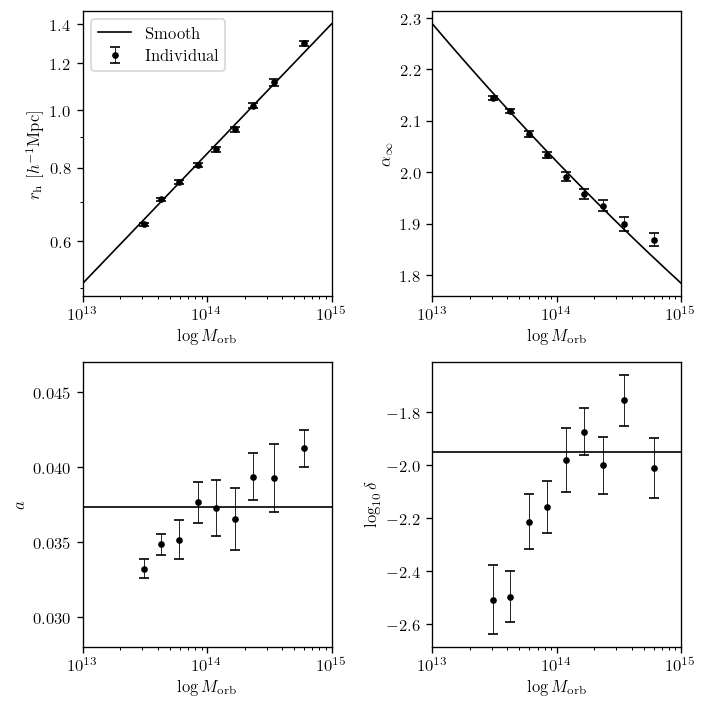

In [5]:
plabels = [r'$r_{\rm h}~[h^{-1}{\rm Mpc}]$', r'$\alpha_{\infty}$', r'$a$',
           r"$\log_{10}\delta$"]
pars = np.zeros((NMBINS, 4))
errs = np.zeros((NMBINS, 4))
mass_pred = np.logspace(13, 15, num=100, base=10)

with h5.File(SRC_PATH + "/fits/mle.h5", 'r') as hdf_load:
    for k, mbin in enumerate(MBINSTRS):
        pars[k, :] = hdf_load[f'max_posterior/orb/{mbin}'][()]
        errs[k, :] = np.sqrt(np.diag(hdf_load[f'covariance/orb/{mbin}'][()]))
    pars_smooth = hdf_load[f'max_posterior/orb/smooth'][()]

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 120})
_, axes = plt.subplots(2, 2, figsize=(6, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

for i, ax in enumerate(axes.flatten()):
    ax.set_xlabel(r'$\log M_{\rm orb}$')
    ax.set_xlim(1e13, 1e15)
    ax.set_xscale('log', base=10)
    ax.set_ylabel(plabels[i])
    ax.errorbar(mass, pars[:, i], yerr=errs[:, i], fmt='.',
                elinewidth=0.5, capsize=3, color='k', label="Individual")

ax1.plot(mass_pred, power_law(mass_pred/M_PIVOT, *pars_smooth[:2]), color='k', 
         lw=1.0, label="Smooth")
# ax1.plot(mass_pred, power_law(mass_pred/M_PIVOT, 0.844, 0.221), color='b', 
#          lw=1.0, alpha=0.5)
ax1.set_yscale('log')
ax1.set_yticks([0.6, 0.8, 1.0, 1.2, 1.4])
ax1.set_yticklabels(['0.6', '0.8', '1.0', '1.2', '1.4'])
ax1.legend(loc="upper left")

ax2.plot(mass_pred, power_law(mass_pred/M_PIVOT, *pars_smooth[2:4]), color='k', 
         lw=1.0)
# ax2.plot(mass_pred, power_law(mass_pred/M_PIVOT, 2.021, -0.053), color='b', 
#          lw=1.0, alpha=0.5)

ax3.hlines(pars_smooth[4], 1e13, 1e15, color='k', lw=1.0)
# ax3.hlines(0.038, 1e13, 1e15, color='b', lw=1.0, alpha=0.5)
ax3.set_ylim(0.028, 0.047)
ax3.set_yticks([0.03, 0.035, 0.04, 0.045])

ax4.hlines(pars_smooth[-1], 1e13, 1e15, color='k', lw=1.0)
# ax4.hlines(-1.99, 1e13, 1e15, color='b', lw=1.0, alpha=0.5)

plt.tight_layout();

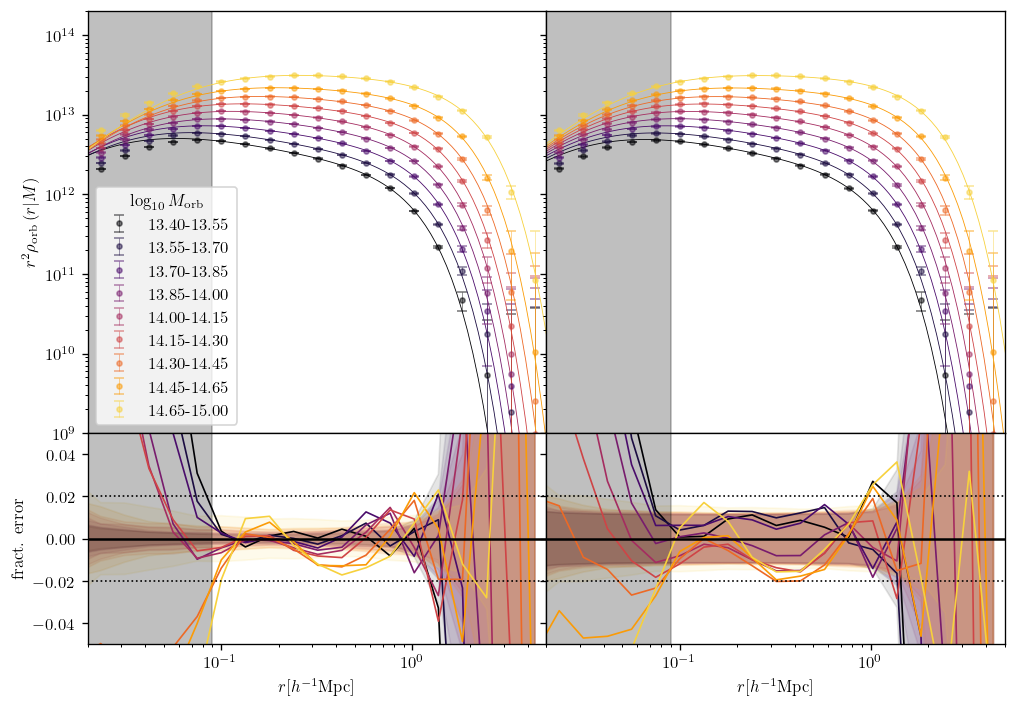

In [4]:
from src.model import rho_orb_model

# Load data
with h5.File(join(SRC_PATH, 'data/xihm_split.h5'), 'r') as hdf_load:
    r = hdf_load['rbins'][()]
    rho = np.zeros((NMBINS, len(r)))
    rho_err = np.zeros((NMBINS, len(r)))
    rho_err_smooth = np.zeros((NMBINS, len(r)))
    for k, mbin in enumerate(MBINSTRS):
        rho[k, :] = hdf_load[f'rho/orb/{mbin}'][()]  # y
        rho_err[k, :] = np.sqrt(np.diag(RHOM**2 * hdf_load[f"xi_cov/all/{mbin}"][()]))
        rho_err_smooth[k, :] = np.sqrt(np.diag(RHOM**2 * hdf_load[f"xi_cov/all/{mbin}"][()]) + (10**pars_smooth[-1]*rho[k, :])**2)

# Setup canvas   
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 120})     
fig, axes = plt.subplots(2, 2, figsize=(8.571428571, 6), sharex=True,
                         sharey='row', gridspec_kw={'hspace': 0,
                                                    'wspace': 0,
                                                    'height_ratios': [2, 1]})
ax1, ax3, ax2, ax4 = axes.flatten()

# Plot all mass bins.
for k, mbin in enumerate(MBINSTRS):
    # Evaluate model over grid for individual profiles
    r_pred = np.logspace(-2, np.log10(max(r+1)), num=100, base=10)
    rho_pred = rho_orb_model(r_pred, *pars[k, :-1], mass[k])
    ratio = rho_orb_model(r, *pars[k, :-1], mass[k]) / rho[k, :] - 1

    # Evaluate model over grid for smooth profiles
    rh = power_law(mass[k]/M_PIVOT, *pars_smooth[:2])
    ainf = power_law(mass[k]/M_PIVOT, *pars_smooth[2:4])
    rho_pred_smooth = rho_orb_model(r_pred, rh, ainf, pars_smooth[-2], mass[k])
    ratio_smooth = rho_orb_model(r, rh, ainf, pars_smooth[-2], mass[k]) / rho[k, :] - 1

    # Plot data and fitted model
    ax1.errorbar(r, r**(2) * rho[k, :], yerr=r**(2) * rho_err[k, :], fmt='.',
                elinewidth=0.5, capsize=3, color=CMAP(k/NMBINS), alpha=0.5,
                label=f'{mbin}')
    ax3.errorbar(r, r**(2) * rho[k, :], yerr=r**(2) * rho_err_smooth[k, :], fmt='.',
                elinewidth=0.5, capsize=3, color=CMAP(k/NMBINS), alpha=0.5)
    
    ax1.plot(r_pred, r_pred**(2) * rho_pred, ls='-', lw=0.5, 
             color=CMAP(k/NMBINS))
    ax3.plot(r_pred, r_pred**(2) * rho_pred_smooth, ls='-', lw=0.5, 
             color=CMAP(k/NMBINS))

    # Plot ratio and error bands
    ax2.plot(r, ratio, lw=1, color=CMAP(k/NMBINS))
    ax2.fill_between(r, rho_err[k, :]/rho[k, :], - rho_err[k, :]/rho[k, :],
                     color=CMAP(k/NMBINS), alpha=0.1)
    
    ax4.plot(r, ratio_smooth, lw=1, color=CMAP(k/NMBINS))
    ax4.fill_between(r, rho_err_smooth[k, :]/rho[k, :], 
                     - rho_err_smooth[k, :]/rho[k, :],
                     color=CMAP(k/NMBINS), alpha=0.1)

# Canvas attributes
ax1.set_yscale('log')
ax1.set_ylabel(r'$r^2\rho_{\rm orb}\left(r|M\right)$')
ax1.set_ylim(1e9, 2e14)
ax1.legend(loc='lower left', title=r'$\log_{10}M_{\rm orb}$')

ax2.set_xlabel(r'$r [h^{-1}{\rm Mpc}]$')
ax4.set_xlabel(r'$r [h^{-1}{\rm Mpc}]$')
ax2.hlines(0, 0, 6, color='k')
ax2.hlines(0.02, 0, 6, color='k', ls=':', lw=1.0)
ax2.hlines(-0.02, 0, 6, color='k', ls=':', lw=1.0)
ax4.hlines(0, 0, 6, color='k')
ax4.hlines(0.02, 0, 6, color='k', ls=':', lw=1.0)
ax4.hlines(-0.02, 0, 6, color='k', ls=':', lw=1.0)
ax2.set_xscale('log')
ax2.set_ylabel(r'fract. error')
ax2.set_ylim(-0.05, 0.05)
ax2.set_yticks([-0.04, -0.02, 0, 0.02, 0.04])

for ax in axes.flatten():
    ax.tick_params(axis='both', which='major')
    ax.fill_betweenx([-1, 1e16], 0, 6*RSOFT, color='k', alpha=0.25)
    ax2.set_xlim(2e-2, 5)
plt.tight_layout();

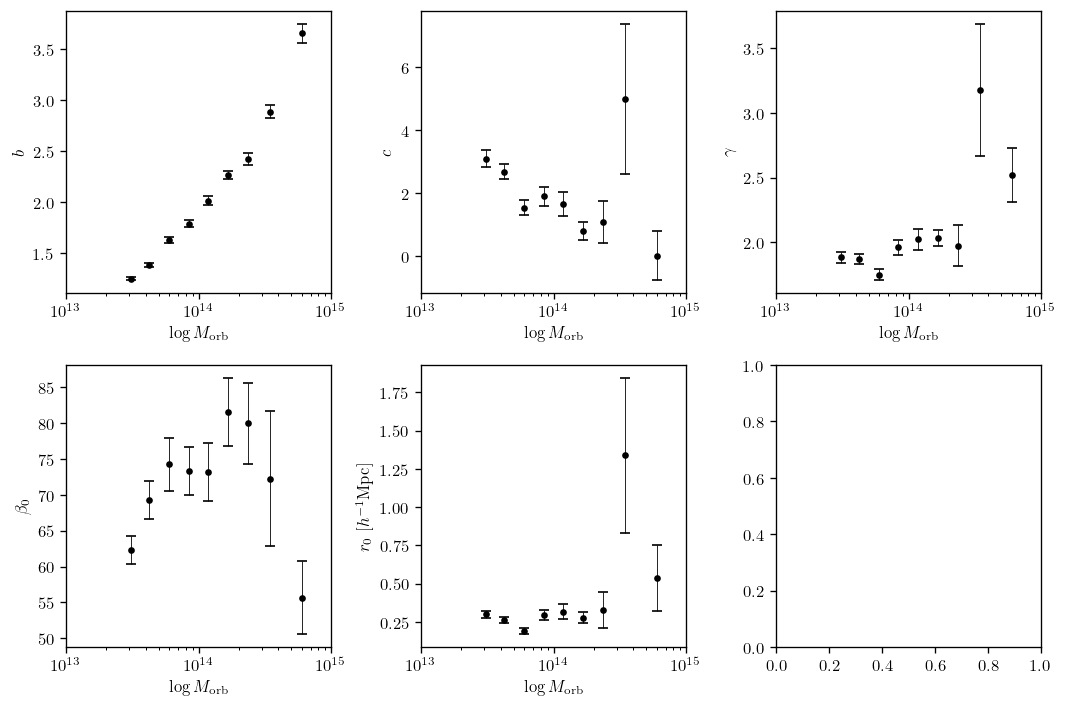

In [5]:
plabels = [r'$b$', r'$c$', r'$\gamma$', r'$\beta_0$', 
           r'$r_{0}~[h^{-1}{\rm Mpc}]$']
pars = np.zeros((NMBINS, 5))
errs = np.zeros((NMBINS, 5))
mass_pred = np.logspace(13, 15, num=100, base=10)

with h5.File(SRC_PATH + "/fits/mle.h5", 'r') as hdf_load:
    for k, mbin in enumerate(MBINSTRS):
        pars[k, :] = hdf_load[f'max_posterior/inf/{mbin}'][()]
        errs[k, :] = np.sqrt(np.diag(hdf_load[f'covariance/inf/{mbin}'][()]))
    # pars_smooth = hdf_load[f'max_posterior/orb/smooth'][()]

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "figure.dpi": 120})
_, axes = plt.subplots(2, 3, figsize=(9, 6))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_xlabel(r'$\log M_{\rm orb}$')
    ax.set_xlim(1e13, 1e15)
    ax.set_xscale('log', base=10)
    ax.set_ylabel(plabels[i])
    ax.errorbar(mass, pars[:, i], yerr=errs[:, i], fmt='.',
                elinewidth=0.5, capsize=3, color='k', label="Individual")

# ax1.plot(mass_pred, power_law(mass_pred/M_PIVOT, *pars_smooth[:2]), color='k', 
#          lw=1.0, label="Smooth")
# # ax1.plot(mass_pred, power_law(mass_pred/M_PIVOT, 0.844, 0.221), color='b', 
# #          lw=1.0, alpha=0.5)
# ax1.set_yscale('log')
# ax1.set_yticks([0.6, 0.8, 1.0, 1.2, 1.4])
# ax1.set_yticklabels(['0.6', '0.8', '1.0', '1.2', '1.4'])
# ax1.legend(loc="upper left")

# ax2.plot(mass_pred, power_law(mass_pred/M_PIVOT, *pars_smooth[2:4]), color='k', 
#          lw=1.0)
# # ax2.plot(mass_pred, power_law(mass_pred/M_PIVOT, 2.021, -0.053), color='b', 
# #          lw=1.0, alpha=0.5)

# ax3.hlines(pars_smooth[4], 1e13, 1e15, color='k', lw=1.0)
# # ax3.hlines(0.038, 1e13, 1e15, color='b', lw=1.0, alpha=0.5)
# ax3.set_ylim(0.028, 0.047)
# ax3.set_yticks([0.03, 0.035, 0.04, 0.045])

# ax4.hlines(pars_smooth[-1], 1e13, 1e15, color='k', lw=1.0)
# ax4.hlines(-1.99, 1e13, 1e15, color='b', lw=1.0, alpha=0.5)

plt.tight_layout();